<a href="https://colab.research.google.com/github/arafaelll/tarefa-ebac/blob/main/Projeto_bank_transaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto de transações bancárias**

## **Objetivos**

1 - Fazer a coleta de dados.

2 - Fazer a modelagem dos dados 'Data Wrangling'.

3 - Analisar a qualidade da conexão e como ela afeta a taxa de sucesso ou falha nas transações.


# **1 - Coleta de dados**

Dados extraidos através do **Kaggle** https://www.kaggle.com/datasets/ziya07/transaction-data-for-banking-operations/data para fins didáticos.

In [222]:
# bibliotecas

import kagglehub
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [223]:
# Download ultima versao

path = kagglehub.dataset_download("ziya07/transaction-data-for-banking-operations")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ziya07/transaction-data-for-banking-operations/versions/1


In [224]:
# Criando um arquivo csv

df = pd.read_csv("/root/.cache/kagglehub/datasets/ziya07/transaction-data-for-banking-operations/versions/1/transaction_data.csv")
df.head()

,Transaction ID,Sender Account ID,Receiver Account ID,Transaction Amount,Transaction Type,Timestamp,Transaction Status,Fraud Flag,Geolocation (Latitude/Longitude),Device Used,Network Slice ID,Latency (ms),Slice Bandwidth (Mbps),PIN Code
0,TXN9520068950,ACC14994,ACC16656,495.90,Deposit,2025-01-17 10:14:00,Failed,True,"34.0522 N, -74.006 W",Desktop,Slice3,10,179,3075
1,TXN9412011085,ACC58958,ACC32826,529.62,Withdrawal,2025-01-17 10:51:00,Success,False,"35.6895 N, -118.2437 W",Mobile,Slice2,11,89,2369
2,TXN4407425052,ACC56321,ACC92481,862.47,Withdrawal,2025-01-17 10:50:00,Failed,False,"48.8566 N, 2.3522 W",Mobile,Slice1,4,53,8039
3,TXN2214150284,ACC48650,ACC76457,1129.88,Transfer,2025-01-17 10:56:00,Success,True,"34.0522 N, -74.006 W",Mobile,Slice3,10,127,6374
4,TXN4247571145,ACC60921,ACC11419,933.24,Deposit,2025-01-17 10:25:00,Success,True,"55.7558 N, 37.6173 W",Mobile,Slice3,20,191,8375


In [225]:
# Criando uma pasta para o arquivo csv

os.makedirs("/content/dados_projeto/", exist_ok=True)

In [226]:
df.to_csv("/content/dados_projeto/transaction_data.csv", index=False)

# **2 - Modelagem**

In [227]:
# Selecionar as colunas desejadas para análises

df_colunas = df[["Transaction Status", "Latency (ms)","Network Slice ID"]]
df_colunas.head()

,Transaction Status,Latency (ms),Network Slice ID
0,Failed,10,Slice3
1,Success,11,Slice2
2,Failed,4,Slice1
3,Success,10,Slice3
4,Success,20,Slice3


In [228]:
# Renomear as colunas

df_colunas_name = df_colunas.rename(columns={'Latency (ms)': 'latency_ms', 'Transaction Status': 'transaction_status', 'Network Slice ID': 'network_slice_id'})

In [229]:
df_colunas_name.head()

,transaction_status,latency_ms,network_slice_id
0,Failed,10,Slice3
1,Success,11,Slice2
2,Failed,4,Slice1
3,Success,10,Slice3
4,Success,20,Slice3


In [230]:
df_colunas_name.shape

(1000, 3)

In [231]:
df_colunas_name.describe()

,latency_ms
count,1000.000000
mean,11.688000
std,5.131958
min,3.000000
25%,7.000000
50%,12.000000
75%,16.000000
max,20.000000


In [232]:
print(df_colunas_name.dtypes)

transaction_status    object
latency_ms             int64
network_slice_id      object
dtype: object


In [233]:
df_contagem = df_colunas_name.pivot_table(index='latency_ms', columns='transaction_status', aggfunc='size', fill_value=0)

In [234]:
print(df_contagem)

transaction_status  Failed  Success
latency_ms                         
3                       20       31
4                       27       22
5                       20       22
6                       28       35
7                       34       30
8                       21       23
9                       36       23
10                      28       35
11                      34       27
12                      24       19
13                      28       26
14                      23       31
15                      39       35
16                      29       19
17                      39       23
18                      25       26
19                      34       31
20                      24       29


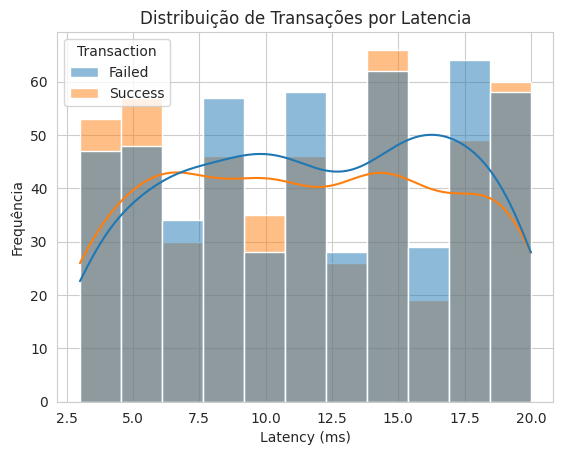

In [235]:
with sns.axes_style('whitegrid'):

  grafico = sns.histplot(data=df_colunas_name, x='latency_ms', hue='transaction_status', kde=True)
  grafico.set(title='Distribuição de Transações por Latencia', xlabel='Latency (ms)', ylabel='Frequência');
  grafico.get_legend().set_title("Transaction");

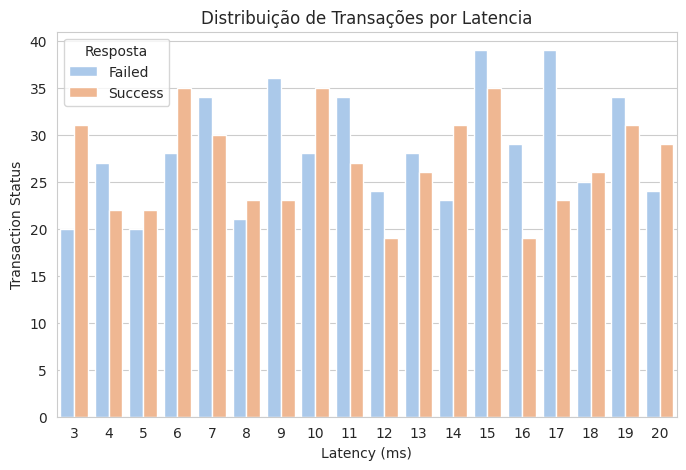

In [236]:
with sns.axes_style('whitegrid'):

  plt.figure(figsize=(8,5))
  sns.countplot(data=df_colunas_name, x='latency_ms', hue='transaction_status', palette='pastel')
  plt.xlabel("Latency (ms)")
  plt.ylabel("Transaction Status")
  plt.title("Distribuição de Transações por Latencia")
  plt.legend(title="Resposta")

Após analizar os gráficos, não podemos concluir que a alta latência está relacionada a um maior número de falhas, mas observamos que entre a latência 15 e 17 possui uma maior quantidade de transações falhas.

In [237]:
# Contagem de redes

df_contagem_network_slice_id = df_colunas_name.pivot_table(index='network_slice_id', columns='transaction_status', aggfunc='size', fill_value=0)
print(df_contagem_network_slice_id)

transaction_status  Failed  Success
network_slice_id                   
Slice1                 168      155
Slice2                 175      165
Slice3                 170      167


In [238]:
# Calcular a porcentagem de falhas

df_contagem_network_slice_id['porcentagem_falhas_mais'] = 100 * (df_contagem_network_slice_id['Failed'] - df_contagem_network_slice_id['Success']) / (df_contagem_network_slice_id['Success'])
print(df_contagem_network_slice_id)

transaction_status  Failed  Success  porcentagem_falhas_mais
network_slice_id                                            
Slice1                 168      155                 8.387097
Slice2                 175      165                 6.060606
Slice3                 170      167                 1.796407


Conclui-se que a rede Slice 1 possui mais porcentagem de falha em relação as outras com o valor de 8.38% de falhas a mais que sucesso.

verficando a relação a latencia com a rede

In [239]:
df_contagem_final = df_colunas_name[['network_slice_id', 'latency_ms', 'transaction_status']].pivot_table(index='network_slice_id', columns=['latency_ms', 'transaction_status'], aggfunc='size', fill_value=0)
print(df_contagem_final)

latency_ms             3              4              5              6   \
transaction_status Failed Success Failed Success Failed Success Failed   
network_slice_id                                                         
Slice1                  7      11      7      11     10       4     11   
Slice2                  8      10     12       5      6      10     10   
Slice3                  5      10      8       6      4       8      7   

latency_ms                     7           ...     16             17          \
transaction_status Success Failed Success  ... Failed Success Failed Success   
network_slice_id                           ...                                 
Slice1                   8      7       8  ...      8       9     14       7   
Slice2                  13     18      10  ...     12       5      7       6   
Slice3                  14      9      12  ...      9       5     18      10   

latency_ms             18             19             20          
transact

In [240]:
df_contagem_final.describe()

latency_ms                3                     4                     5   \
transaction_status    Failed    Success     Failed    Success     Failed   
count               3.000000   3.000000   3.000000   3.000000   3.000000   
mean                6.666667  10.333333   9.000000   7.333333   6.666667   
std                 1.527525   0.577350   2.645751   3.214550   3.055050   
min                 5.000000  10.000000   7.000000   5.000000   4.000000   
25%                 6.000000  10.000000   7.500000   5.500000   5.000000   
50%                 7.000000  10.000000   8.000000   6.000000   6.000000   
75%                 7.500000  10.500000  10.000000   8.500000   8.000000   
max                 8.000000  11.000000  12.000000  11.000000  10.000000   

latency_ms                            6                     7           ...  \
transaction_status    Success     Failed    Success     Failed Success  ...   
count                3.000000   3.000000   3.000000   3.000000     3.0  ...   
mean                 7.333333   9.333333  11.666667  11.333333    10.0  ...   
std                  3.055050   2.081666   3.214550   5.859465     2.0  ...   
min                  4.000000   7.000000   8.000000   7.000000     8.0  ...   
25%                  6.000000   8.500000  10.500000   8.000000     9.0  ...   
50%                  8.000000  10.000000  13.000000   9.000000    10.0  ...   
75%                  9.000000  10.500000  13.500000  13.500000    11.0  ...   
max                 10.000000  11.000000  14.000000  18.000000    12.0  ...   

latency_ms                 16                   17                    18  \
transaction_status     Failed   Success     Failed    Success     Failed   
count                3.000000  3.000000   3.000000   3.000000   3.000000   
mean                 9.666667  6.333333  13.000000   7.666667   8.333333   
std                  2.081666  2.309401   5.567764   2.081666   3.511885   
min                  8.000000  5.000000   7.000000   6.000000   5.000000   
25%                  8.500000  5.000000  10.500000   6.500000   6.500000   
50%                  9.000000  5.000000  14.000000   7.000000   8.000000   
75%                 10.500000  7.000000  16.000000   8.500000  10.000000   
max                 12.000000  9.000000  18.000000  10.000000  12.000000   

latency_ms                            19                20             
transaction_status    Success     Failed    Success Failed    Success  
count                3.000000   3.000000   3.000000    3.0   3.000000  
mean                 8.666667  11.333333  10.333333    8.0   9.666667  
std                  3.055050   0.577350   2.516611    4.0   2.516611  
min                  6.000000  11.000000   8.000000    4.0   7.000000  
25%                  7.000000  11.000000   9.000000    6.0   8.500000  
50%                  8.000000  11.000000  10.000000    8.0  10.000000  
75%                 10.000000  11.500000  11.500000   10.0  11.000000  
max                 12.000000  12.000000  13.000000   12.0  12.000000  

[8 rows x 36 columns]

# **3 - Conclusões**

Após analisar os gráficos, não podemos concluir que a alta latência está diretamente relacionada a um maior número de falhas. No entanto, observamos que, entre as latências de 15 e 17, há uma maior quantidade de transações com falha.

Além disso, conclui-se que a rede Slice 1 apresenta um percentual maior de falhas em comparação com as demais, registrando 8,38% mais falhas do que sucessos.